# Chessman Image Classification Using MobileNet with Transfer Learning
---------------------------------------------------------------------


In [ ]:

# Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/Users/m1pro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Preparation
---

In [ ]:
# 1. Load the Chessman Image Dataset
dataset_path = '/Users/m1pro/Downloads/Chess'

# 2. Data Preprocessing
image_size = (128, 128)  # Resizing images to 128x128

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Using MobileNet preprocessing
    validation_split=0.2,  # Split for training and validation
    rotation_range=20,  # Data augmentation - rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Shearing
    zoom_range=0.1,  # Zoom
    horizontal_flip=True  # Flipping
)

# Load images and split into training and validation sets
train_data_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 442 images belonging to 6 classes.
Found 109 images belonging to 6 classes.


# Model Selection and Enhancement
---------------------------------------------------------------------

In [ ]:

# 1. Load MobileNet model with pre-trained weights. This model is being used due to its light-weight capabilities and speed.
# We exclude the top layer to customize for our dataset
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# 2. Add custom layers for our classification task
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization for stability
    layers.Dense(6, activation='softmax')  # 6 classes for chess pieces
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,758,790 (14.34 MB)

 Trainable params: 528,902 (2.02 MB)

 Non-trainable params: 3,229,888 (12.32 MB)


# Training
---------------------------------------------------------------------

In [ ]:
# Implement Callbacks: Early Stopping and Model Checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True)

# Train the Model
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=30,
    callbacks=[model_checkpoint]
    # callbacks=[early_stopping, model_checkpoint]
)


/Users/m1pro/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.2655 - loss: 2.1612 - val_accuracy: 0.5046 - val_loss: 1.3220
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.6393 - loss: 1.0254 - val_accuracy: 0.6514 - val_loss: 1.0412
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.7317 - loss: 0.7700 - val_accuracy: 0.7431 - val_loss: 0.6812
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.7476 - loss: 0.6755 - val_accuracy: 0.7890 - val_loss: 0.6229
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.7121 - loss: 0.7237 - val_accuracy: 0.8073 - val_loss: 0.5244
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.7490 - loss: 0.6626 - val_accuracy: 0.7431 - val_loss: 0.5635
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.8219 - loss: 0.4994 - val_accuracy: 0.7248 - val_loss: 0.6560
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.8231 - loss: 0.4615 - val_accuracy: 0.

# Evaluation
--------------------------------------------------------------------

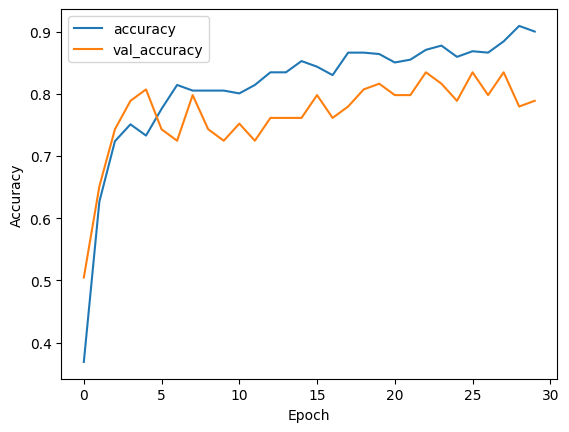

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step


In [ ]:

# 1. Plot Training History
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load the best model and evaluate
model.load_weights('best_mobilenet_model.keras')

# Generate predictions on the validation set
val_data_gen.reset()
predictions = model.predict(val_data_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data_gen.classes


              precision    recall  f1-score   support

      Bishop       0.33      0.41      0.37        17
        King       0.00      0.00      0.00        15
      Knight       0.11      0.10      0.10        21
        Pawn       0.17      0.14      0.15        21
       Queen       0.15      0.27      0.19        15
        Rook       0.06      0.05      0.06        20

    accuracy                           0.16       109
   macro avg       0.14      0.16      0.14       109
weighted avg       0.14      0.16      0.14       109



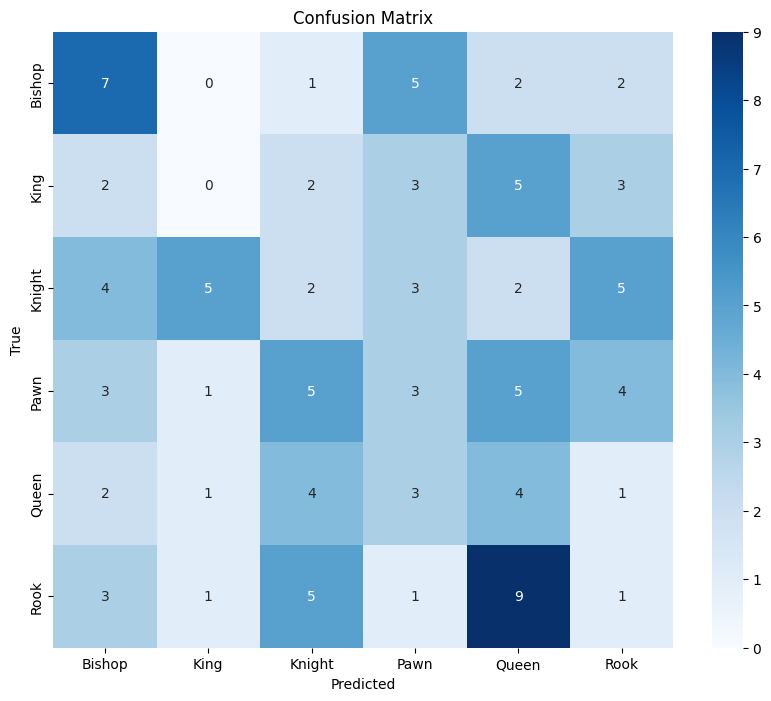

In [6]:

# 2. Classification Report
print(classification_report(y_true, y_pred, target_names=val_data_gen.class_indices.keys()))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_data_gen.class_indices.keys(),
            yticklabels=val_data_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Test Accuracy 

results = model.evaluate(val_data_gen, verbose=0)

print(" Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

 Test Loss: 0.54886
Test Accuracy: 79.82%
